## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib

# from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.utils.franka import reconstruct_actions
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-15 16:09:44.349 | INFO     |  Running on cuda:0


In [3]:
task = 'Coffee'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-15 16:09:45.298 | INFO     |  Loading dataset(s): 
2024-08-15 16:09:45.298 | INFO     |    Initializing datasete using /home/hartzj/MT-GMM/data/Coffee/demos/metadata.json
2024-08-15 16:09:45.299 | INFO     |    Extracted gt object labels []
2024-08-15 16:09:45.299 | INFO     |    Extracted tsdf object labels []
2024-08-15 16:09:45.299 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'exp',
}


In [5]:
observations = scene_data.get_demos(**kp_config)

reconstruct_actions(observations)

n_obs = len(observations)


In [6]:
demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=True,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True,
    kp_indeces=list(range(4)),
)

demos = Demos(observations, **data_kwargs)

2024-08-15 16:09:47.574 | INFO     |  Subsampling to length 481 using strategy mean-length.


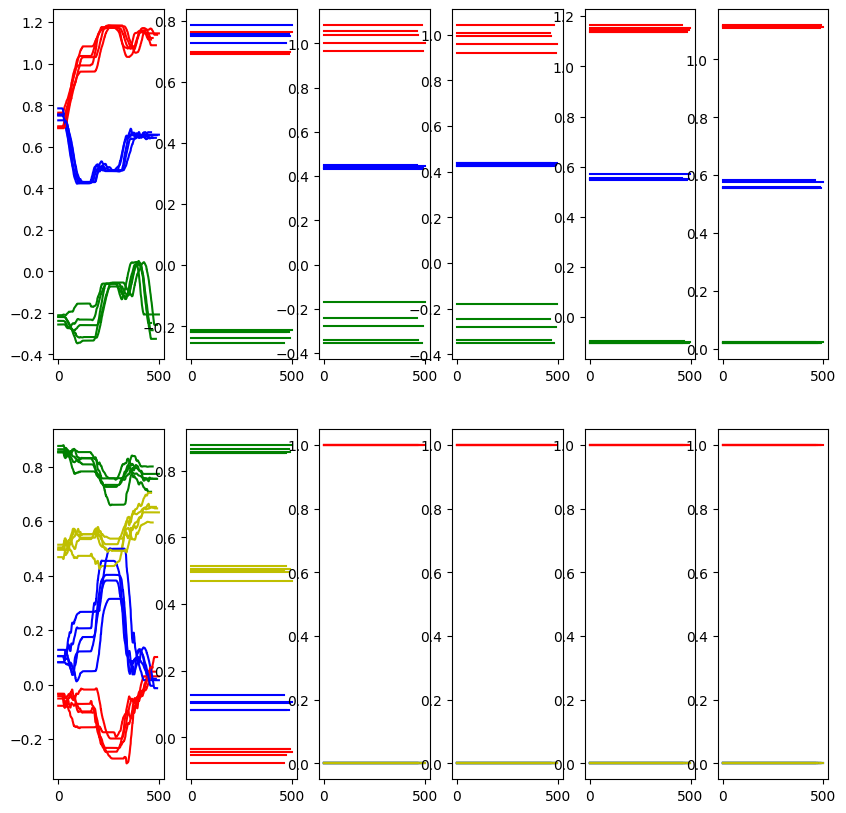

In [7]:
demos.debug_trajs()

In [8]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    action_as_orientation=False,
    action_with_magnitude=False,

    add_gripper_action=True,

    reg_init_diag=5e-5,
    reg_diag_gripper=2e-5,
    reg_em_finish_diag_gripper=2e-5,

    reg_shrink=1e-3,
    reg_diag=5e-5,

    reg_em_finish_shrink=1e-3,
    reg_em_finish_diag=5e-5,

    fix_first_component=False,
    fix_last_component=False,

    trans_cov_mask_t_pos_corr=False,

    em_steps=1,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
)

demo_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,

    use_gripper_states=False,

    min_end_distance=35,
    min_len=4,

    velocity_threshold=0.002,
    max_idx_distance=1,
)

cascade_config = CascadeConfig(
    min_prob=0.05,
    kl_keep_rotation_dim=False
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demo_segmentation_config,
    cascade=cascade_config,
)


In [9]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-15 16:09:48.716 | INFO     |  Fitting AutoTPGMM
2024-08-15 16:09:48.717 | INFO     |  Performing fitting actions: [INIT]
2024-08-15 16:09:48.717 | INFO     |  Segmenting trajectories


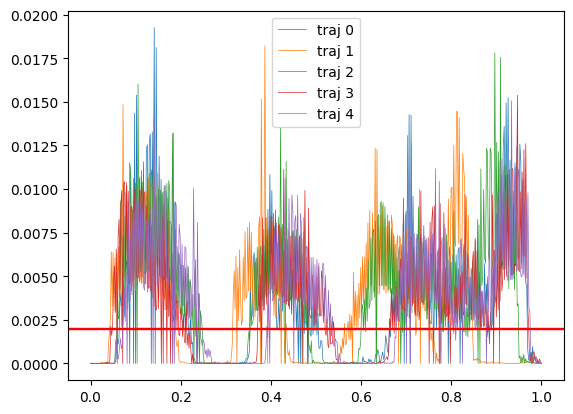

2024-08-15 16:09:48.881 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(382, dtype=torch.int32), tensor(461, dtype=torch.int32)) from traj 1 of len 500
2024-08-15 16:09:48.882 | INFO     |  Creating segement of demos.
2024-08-15 16:09:48.883 | INFO     |  Subsampling to length 138 using strategy mean-length.
2024-08-15 16:09:48.884 | INFO     |  Creating segement of demos.
2024-08-15 16:09:48.885 | INFO     |  Subsampling to length 132 using strategy mean-length.
2024-08-15 16:09:48.886 | INFO     |  Creating segement of demos.
2024-08-15 16:09:48.887 | INFO     |  Subsampling to length 209 using strategy mean-length.
2024-08-15 16:09:48.888 | INFO     |  ... created 3 segments
2024-08-15 16:09:48.888 | INFO     |    Fitting candidate frame 1/5
2024-08-15 16:09:48.888 | INFO     |    Creating partial frame view of demos.
2024-08-15 16:09:48.891 | INFO     |    Manifold: TIME x R3 x QUAT x R1

Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:49.128 | INFO     |    Fitting candidate frame 2/5
2024-08-15 16:09:49.128 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:49.411 | INFO     |    Fitting candidate frame 3/5
2024-08-15 16:09:49.411 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:49.695 | INFO     |    Fitting candidate frame 4/5
2024-08-15 16:09:49.696 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:49.995 | INFO     |    Fitting candidate frame 5/5
2024-08-15 16:09:49.996 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:50.278 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-15 16:09:50.278 | INFO     |  kp 0       score (rel):     -0 (0.489)
2024-08-15 16:09:50.278 | INFO     |  kp 1       score (rel):     -1 (0.543)
2024-08-15 16:09:50.278 | INFO     |  kp 2       score (rel):     -0 (0.309)
2024-08-15 16:09:50.278 | INFO     |  kp 3       score (rel):     -0 (0.228)
2024-08-15 16:09:50.278 | INFO     |  Creating partial frame view of demos.
2024-08-15 16:09:50.355 | INFO     |    Fitting candidate frame 1/5
2024-08-15 16:09:50.355 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:50.588 | INFO     |    Fitting candidate frame 2/5
2024-08-15 16:09:50.588 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:50.891 | INFO     |    Fitting candidate frame 3/5
2024-08-15 16:09:50.891 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:51.221 | INFO     |    Fitting candidate frame 4/5
2024-08-15 16:09:51.222 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:51.535 | INFO     |    Fitting candidate frame 5/5
2024-08-15 16:09:51.535 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:51.842 | INFO     |  ee_init    score (rel):     -0 (0.823)
2024-08-15 16:09:51.842 | INFO     |  kp 0       score (rel):     -0 (0.830)
2024-08-15 16:09:51.843 | INFO     |  kp 1       score (rel):     -1 (1.000)
2024-08-15 16:09:51.843 | INFO     |  kp 2       score (rel):     -0 (0.491)
2024-08-15 16:09:51.843 | INFO     |  kp 3       score (rel):     -0 (0.596)
2024-08-15 16:09:51.843 | INFO     |  Creating partial frame view of demos.
2024-08-15 16:09:51.918 | INFO     |    Fitting candidate frame 1/5
2024-08-15 16:09:51.918 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:52.290 | INFO     |    Fitting candidate frame 2/5
2024-08-15 16:09:52.291 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:52.767 | INFO     |    Fitting candidate frame 3/5
2024-08-15 16:09:52.768 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:53.291 | INFO     |    Fitting candidate frame 4/5
2024-08-15 16:09:53.291 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:53.790 | INFO     |    Fitting candidate frame 5/5
2024-08-15 16:09:53.791 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:54.277 | INFO     |  ee_init    score (rel):     -1 (0.967)
2024-08-15 16:09:54.277 | INFO     |  kp 0       score (rel):     -0 (0.052)
2024-08-15 16:09:54.277 | INFO     |  kp 1       score (rel):     -0 (0.078)
2024-08-15 16:09:54.277 | INFO     |  kp 2       score (rel):     -0 (0.711)
2024-08-15 16:09:54.278 | INFO     |  kp 3       score (rel):     -1 (1.000)
2024-08-15 16:09:54.278 | INFO     |  Creating partial frame view of demos.
2024-08-15 16:09:54.293 | INFO     |  Segmented trajs into 3 segments
2024-08-15 16:09:54.296 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3
Segment 0 -0.998964 -0.488915 -0.542056 -0.309090 -0.227576
Segment 1 -0.446074 -0.450270 -0.542338 -0.266082 -0.322974
Segment 2 -0.545872 -0.029519 -0.044169 -0.401434 -0.564538
2024-08-15 16:09:54.297 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3
Segment 0  1.000000  0.489422  0.542618  0.309411  0.22

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-15 16:09:54.317 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:54.906 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:55.889 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

((array([[6.43e+19, 7.77e+19, 9.23e+19, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [3.14e+08, 1.47e+09, 6.51e+09, ..., 2.35e-52, 1.43e-52, 8.13e-53],
         [3.13e-05, 2.92e-04, 2.55e-03, ..., 1.96e-27, 1.36e-28, 8.78e-30],
         [5.03e-18, 2.99e-17, 1.65e-16, ..., 2.46e-11, 2.79e-12, 2.89e-13],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.98e+12, 1.02e+12, 3.30e+11],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 3.42e+16, 2.54e+16, 1.84e+16]]),
  array([[1.27e+037, 1.59e+037, 1.94e+037, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.22e+032, 3.58e+032, 1.01e+033, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.75e-005, 2.98e-004, 4.59e-003, ..., 3.76e-038, 1.10e-039,
          3.01e-041],
         [3.41e-064, 1.20e-062, 3.76e-061, ..., 3.60e+014, 3.01e+013,
          2.33e+012],
         [1.88e-164, 3.04e-163, 4.43e-162, ..., 3.62e+032, 1.10e+032,
          3.16e+031],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.05e+037, 7.65e+036,
          5.

In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-15 16:09:57.025 | INFO     |  Fitting AutoTPGMM
2024-08-15 16:09:57.026 | INFO     |  Segmenting trajectories


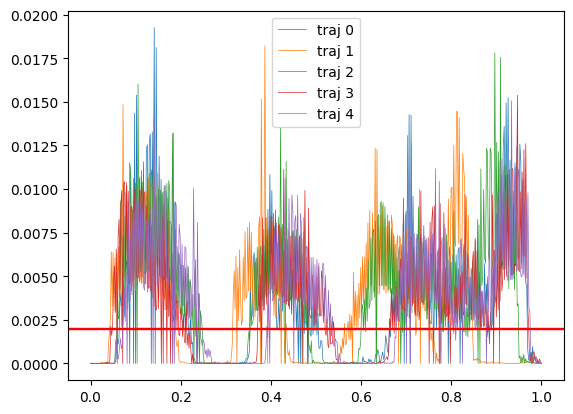

2024-08-15 16:09:57.159 | INFO     |  Creating segement of demos.
2024-08-15 16:09:57.161 | INFO     |  Creating segement of demos.
2024-08-15 16:09:57.163 | INFO     |  Creating segement of demos.
2024-08-15 16:09:57.166 | INFO     |  ... created 3 segments
2024-08-15 16:09:57.166 | INFO     |    Fitting candidate frame 1/5
2024-08-15 16:09:57.166 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:57.404 | INFO     |    Fitting candidate frame 2/5
2024-08-15 16:09:57.404 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:57.719 | INFO     |    Fitting candidate frame 3/5
2024-08-15 16:09:57.719 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:58.008 | INFO     |    Fitting candidate frame 4/5
2024-08-15 16:09:58.009 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:58.298 | INFO     |    Fitting candidate frame 5/5
2024-08-15 16:09:58.299 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:58.603 | INFO     |  Creating partial frame view of demos.
2024-08-15 16:09:58.679 | INFO     |    Fitting candidate frame 1/5
2024-08-15 16:09:58.680 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:58.911 | INFO     |    Fitting candidate frame 2/5
2024-08-15 16:09:58.911 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:59.201 | INFO     |    Fitting candidate frame 3/5
2024-08-15 16:09:59.202 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:59.518 | INFO     |    Fitting candidate frame 4/5
2024-08-15 16:09:59.518 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:09:59.805 | INFO     |    Fitting candidate frame 5/5
2024-08-15 16:09:59.805 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:10:00.099 | INFO     |  Creating partial frame view of demos.
2024-08-15 16:10:00.169 | INFO     |    Fitting candidate frame 1/5
2024-08-15 16:10:00.169 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:10:00.534 | INFO     |    Fitting candidate frame 2/5
2024-08-15 16:10:00.534 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:10:00.967 | INFO     |    Fitting candidate frame 3/5
2024-08-15 16:10:00.967 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:10:01.413 | INFO     |    Fitting candidate frame 4/5
2024-08-15 16:10:01.414 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:10:01.865 | INFO     |    Fitting candidate frame 5/5
2024-08-15 16:10:01.865 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2024-08-15 16:10:02.294 | INFO     |  Creating partial frame view of demos.
2024-08-15 16:10:02.296 | INFO     |  Segmented trajs into 3 segments
2024-08-15 16:10:02.298 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3
Segment 0 -0.998964 -0.488915 -0.542056 -0.309090 -0.227576
Segment 1 -0.446074 -0.450270 -0.542338 -0.266082 -0.322974
Segment 2 -0.545872 -0.029519 -0.044169 -0.401434 -0.564538
2024-08-15 16:10:02.299 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3
Segment 0  1.000000  0.489422  0.542618  0.309411  0.227812
Segment 1  0.822500  0.830239  1.000000  0.490619  0.595522
Segment 2  0.966937  0.052289  0.078240  0.711084  1.000000


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

((array([[6.43e+19, 7.77e+19, 9.23e+19, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [3.14e+08, 1.47e+09, 6.51e+09, ..., 2.35e-52, 1.43e-52, 8.13e-53],
         [3.13e-05, 2.92e-04, 2.55e-03, ..., 1.96e-27, 1.36e-28, 8.78e-30],
         [5.03e-18, 2.99e-17, 1.65e-16, ..., 2.46e-11, 2.79e-12, 2.89e-13],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.98e+12, 1.02e+12, 3.30e+11],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 3.42e+16, 2.54e+16, 1.84e+16]]),
  array([[1.27e+037, 1.59e+037, 1.94e+037, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.22e+032, 3.58e+032, 1.01e+033, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.75e-005, 2.98e-004, 4.59e-003, ..., 3.76e-038, 1.10e-039,
          3.01e-041],
         [3.41e-064, 1.20e-062, 3.76e-061, ..., 3.60e+014, 3.01e+013,
          2.33e+012],
         [1.88e-164, 3.04e-163, 4.43e-162, ..., 3.62e+032, 1.10e+032,
          3.16e+031],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.05e+037, 7.65e+036,
          5.

In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


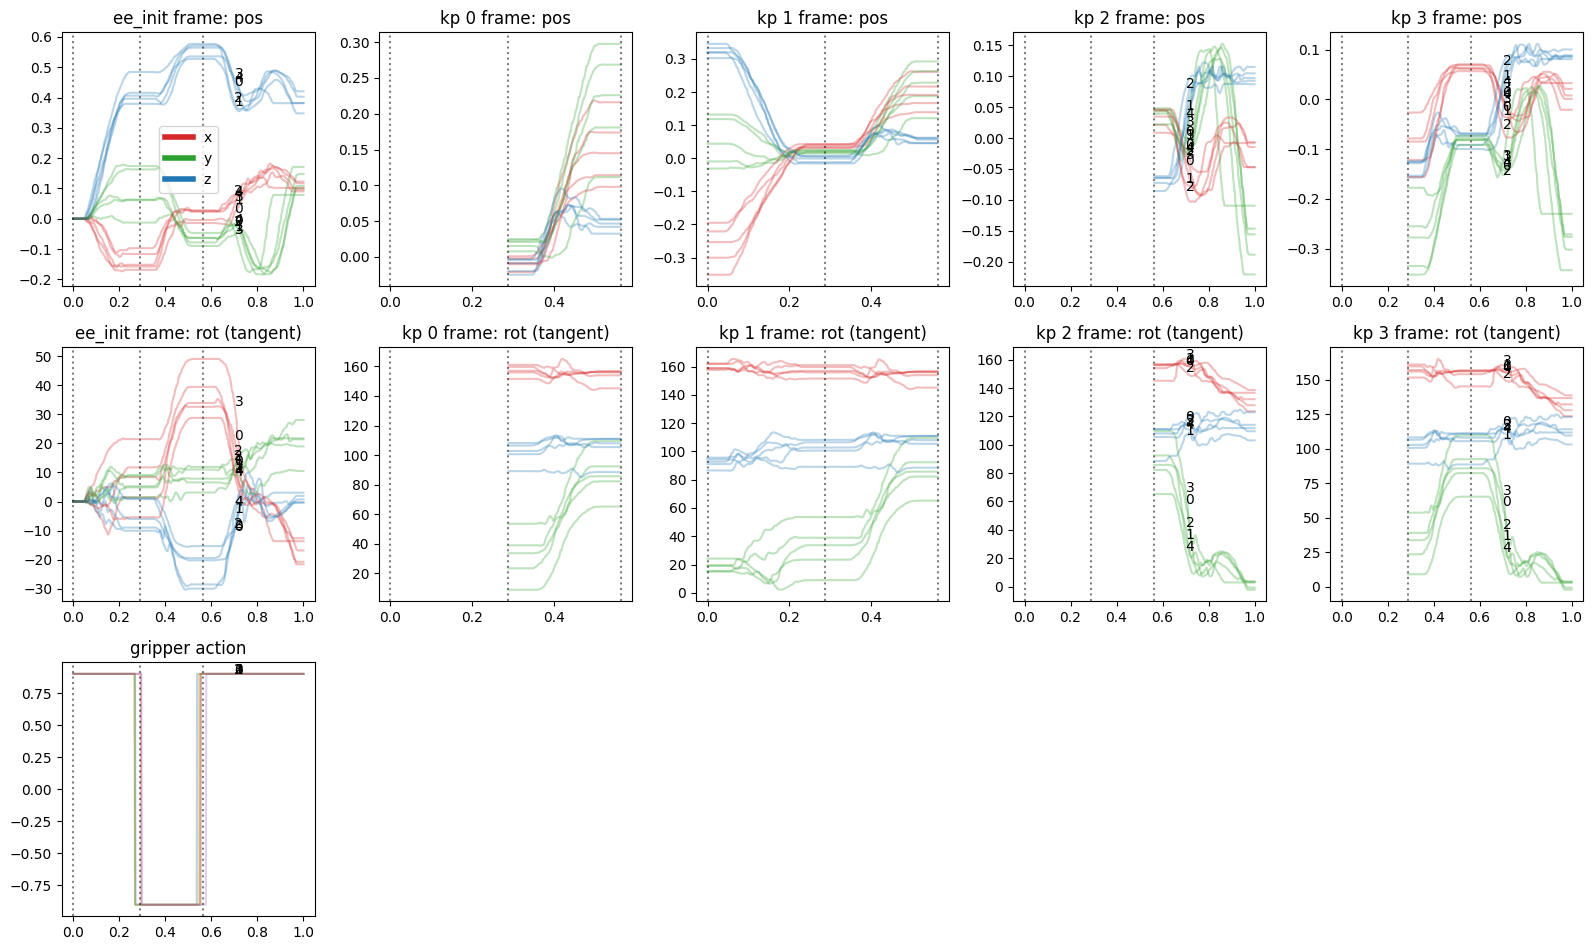

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, time_based=True,)


In [13]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.EM_HMM,))


2024-08-15 16:10:06.195 | INFO     |  Fitting AutoTPGMM
2024-08-15 16:10:06.195 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2024-08-15 16:10:06.199 | INFO     |  HMM EM ...
2024-08-15 16:10:06.204 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-15 16:10:06.262 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-15 16:10:08.007 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [4.88e-12, 1.89e-11, 7.06e-11, ..., 6.89e-69, 5.64e-69, 4.42e-69],
         [4.87e-25, 3.75e-24, 2.77e-23, ..., 5.73e-44, 5.34e-45, 4.78e-46],
         [7.82e-38, 3.85e-37, 1.79e-36, ..., 7.20e-28, 1.10e-28, 1.57e-29],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 8.71e-05, 3.99e-05, 1.80e-05],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [9.65e-006, 2.26e-005, 5.21e-005, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.38e-042, 1.88e-041, 2.37e-040, ..., 3.57e-075, 1.44e-076,
          5.59e-078],
         [2.69e-101, 7.59e-100, 1.94e-098, ..., 3.43e-023, 3.93e-024,
          4.32e-025],
         [1.48e-201, 1.92e-200, 2.29e-199, ..., 3.44e-005, 1.43e-005,
          5.88e-006],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.

2024-08-15 16:10:14.584 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-15 16:10:14.955 | WARNING  |  Skippig NaN Gaussians.


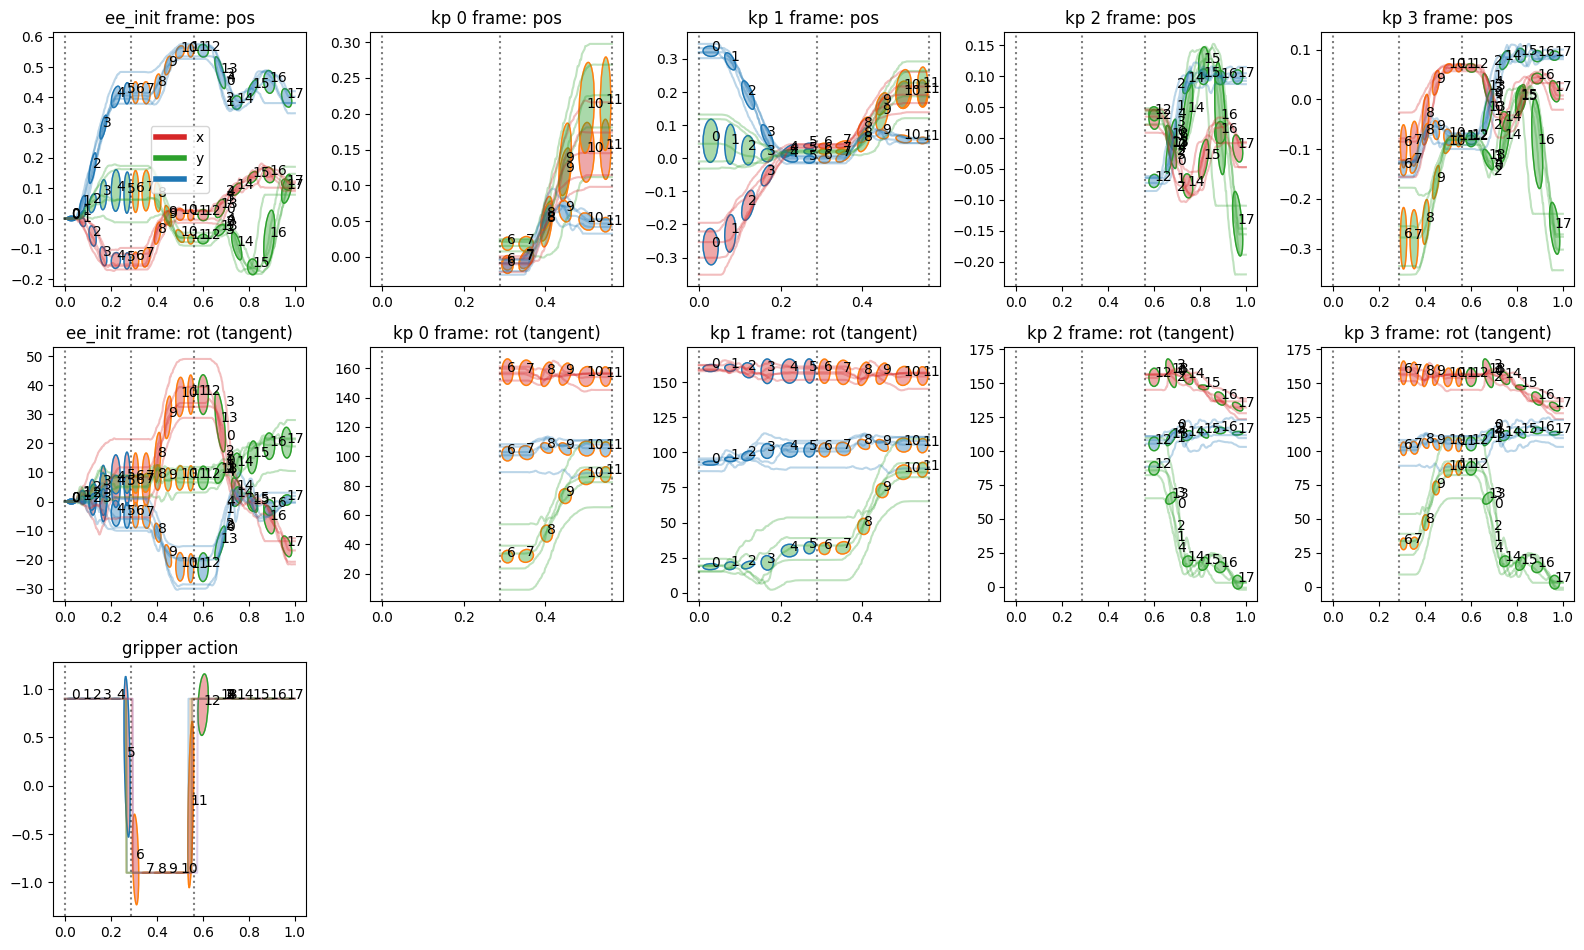

In [14]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


In [15]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-15 16:10:17.606 | INFO     |  Saving model:


2024-08-15 16:10:17.686 | INFO     |  Did not specify time_based, deciding automatically.


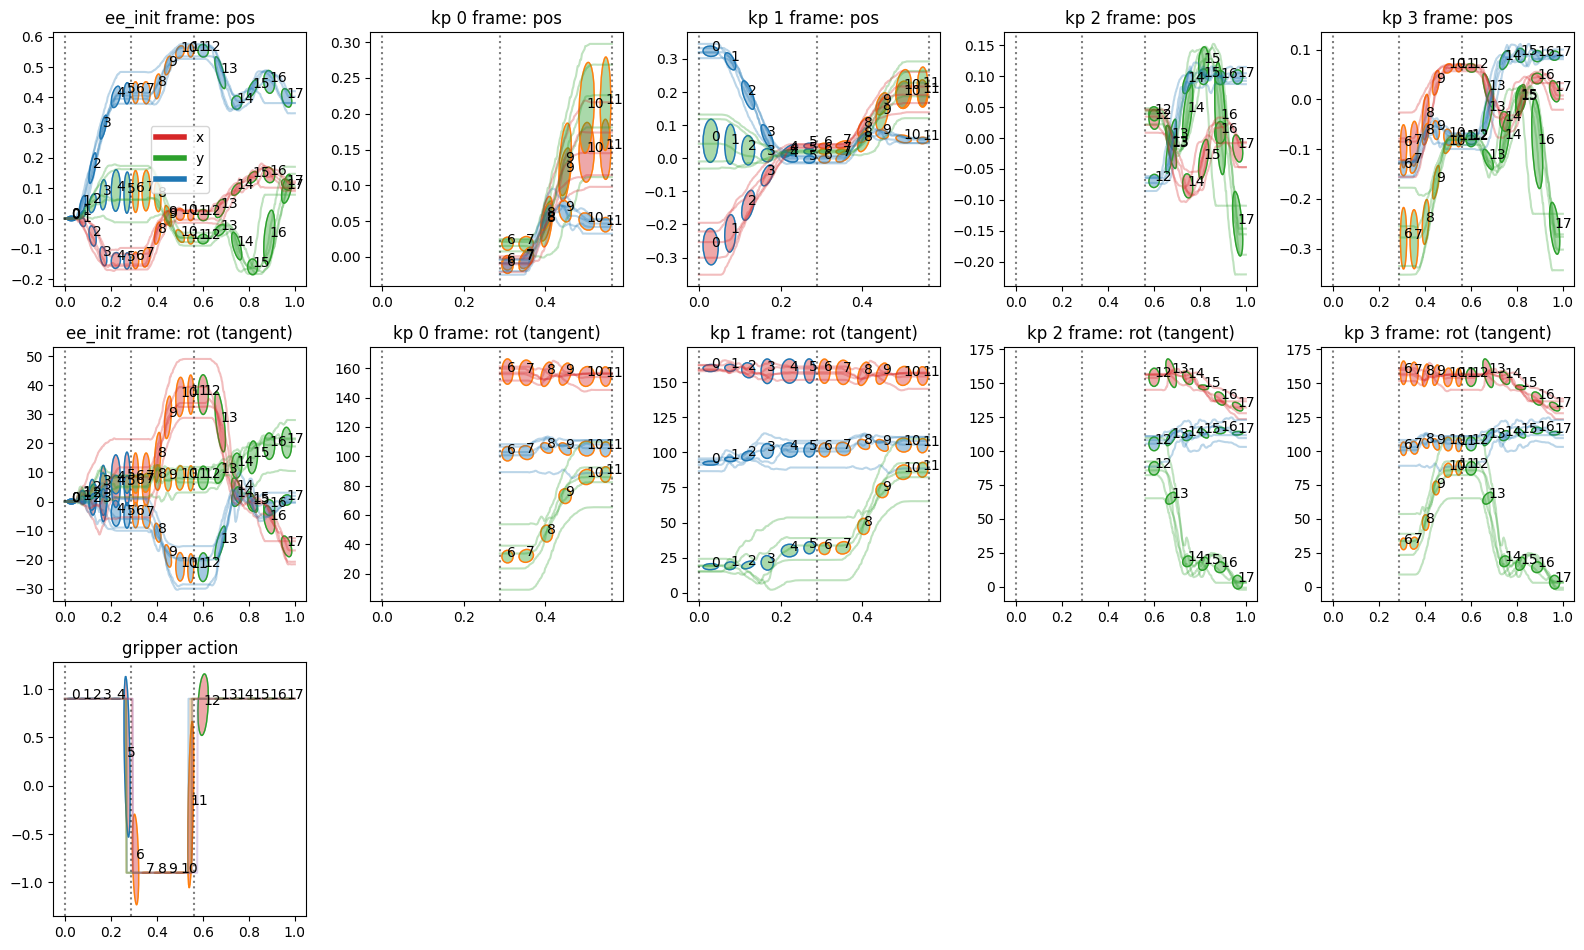

In [16]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


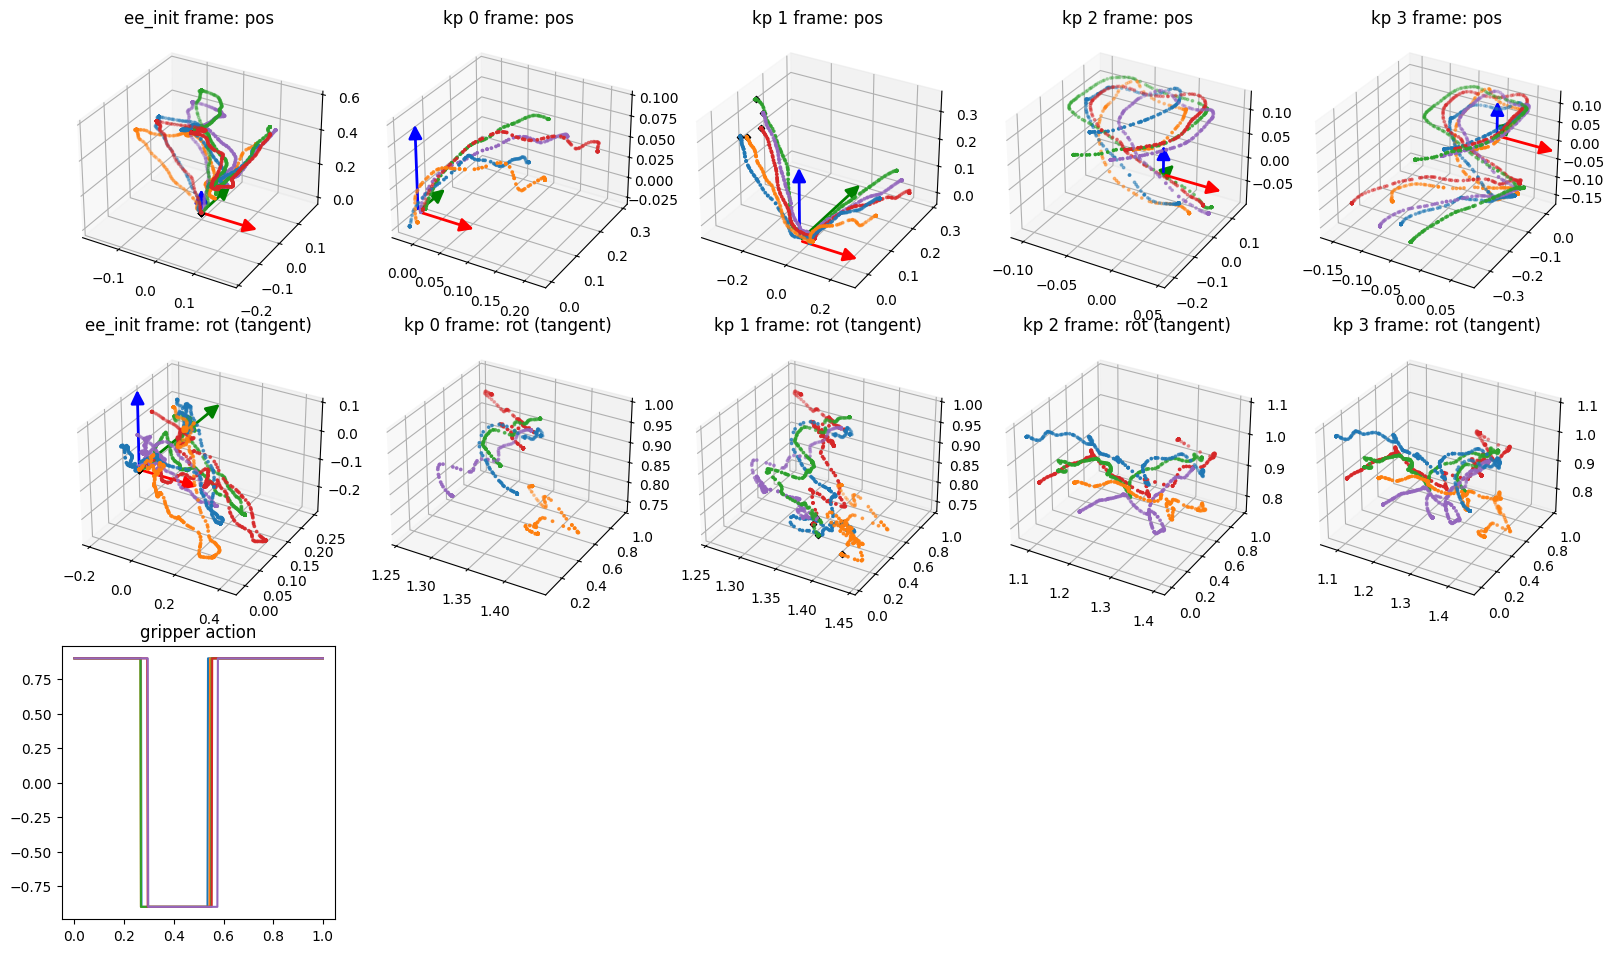

In [17]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [18]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-15 16:10:22.144 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-15 16:10:22.171 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]))
2024-08-15 16:10:22.171 | INFO     |  Creating partial frame view of demos.
2024-08-15 16:10:22.174 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-15 16:10:22.293 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-15 16:10:22.435 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-15 16:10:22.539 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

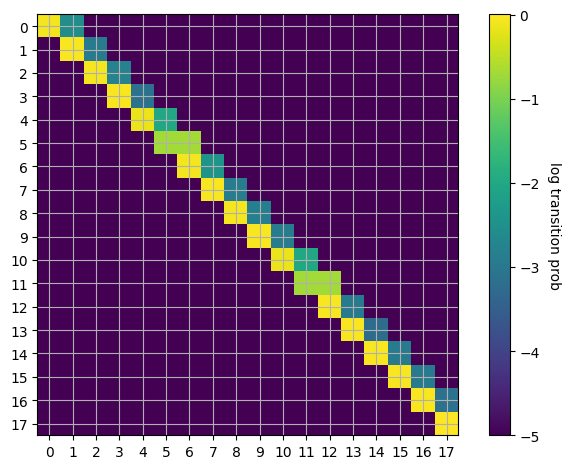

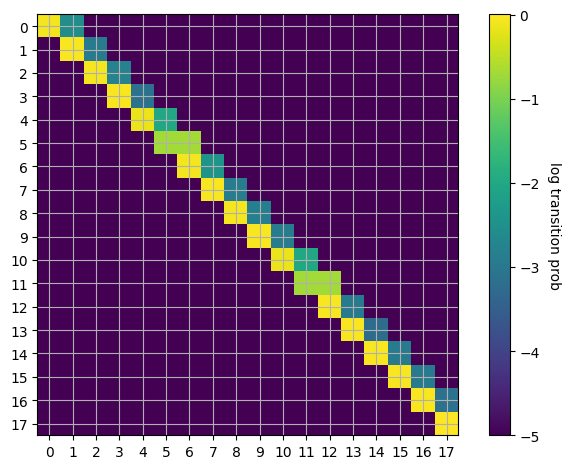

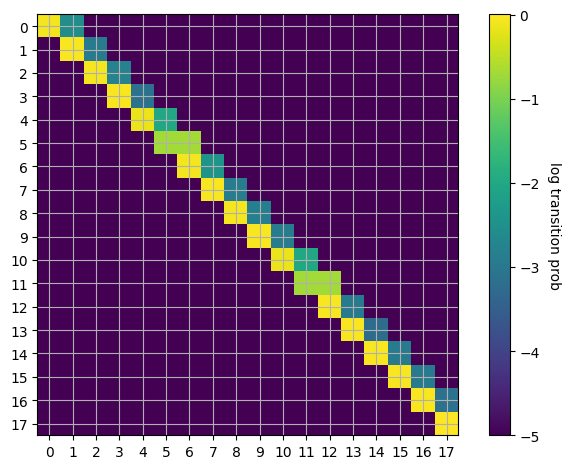

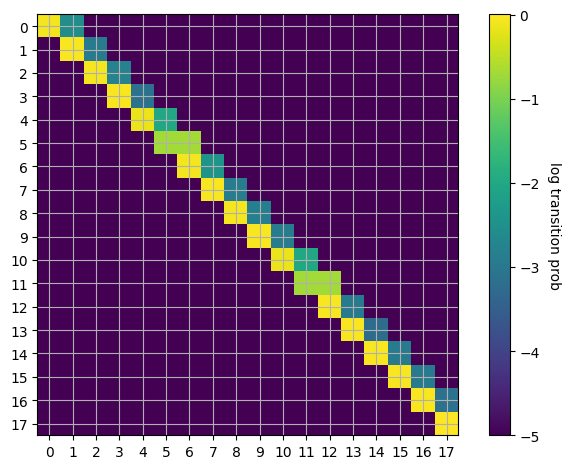

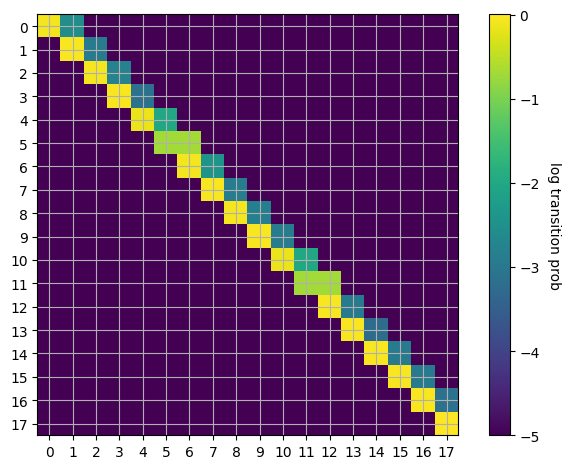

In [19]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)


2024-08-15 16:10:35.548 | INFO     |  Taking frame origins from demos.


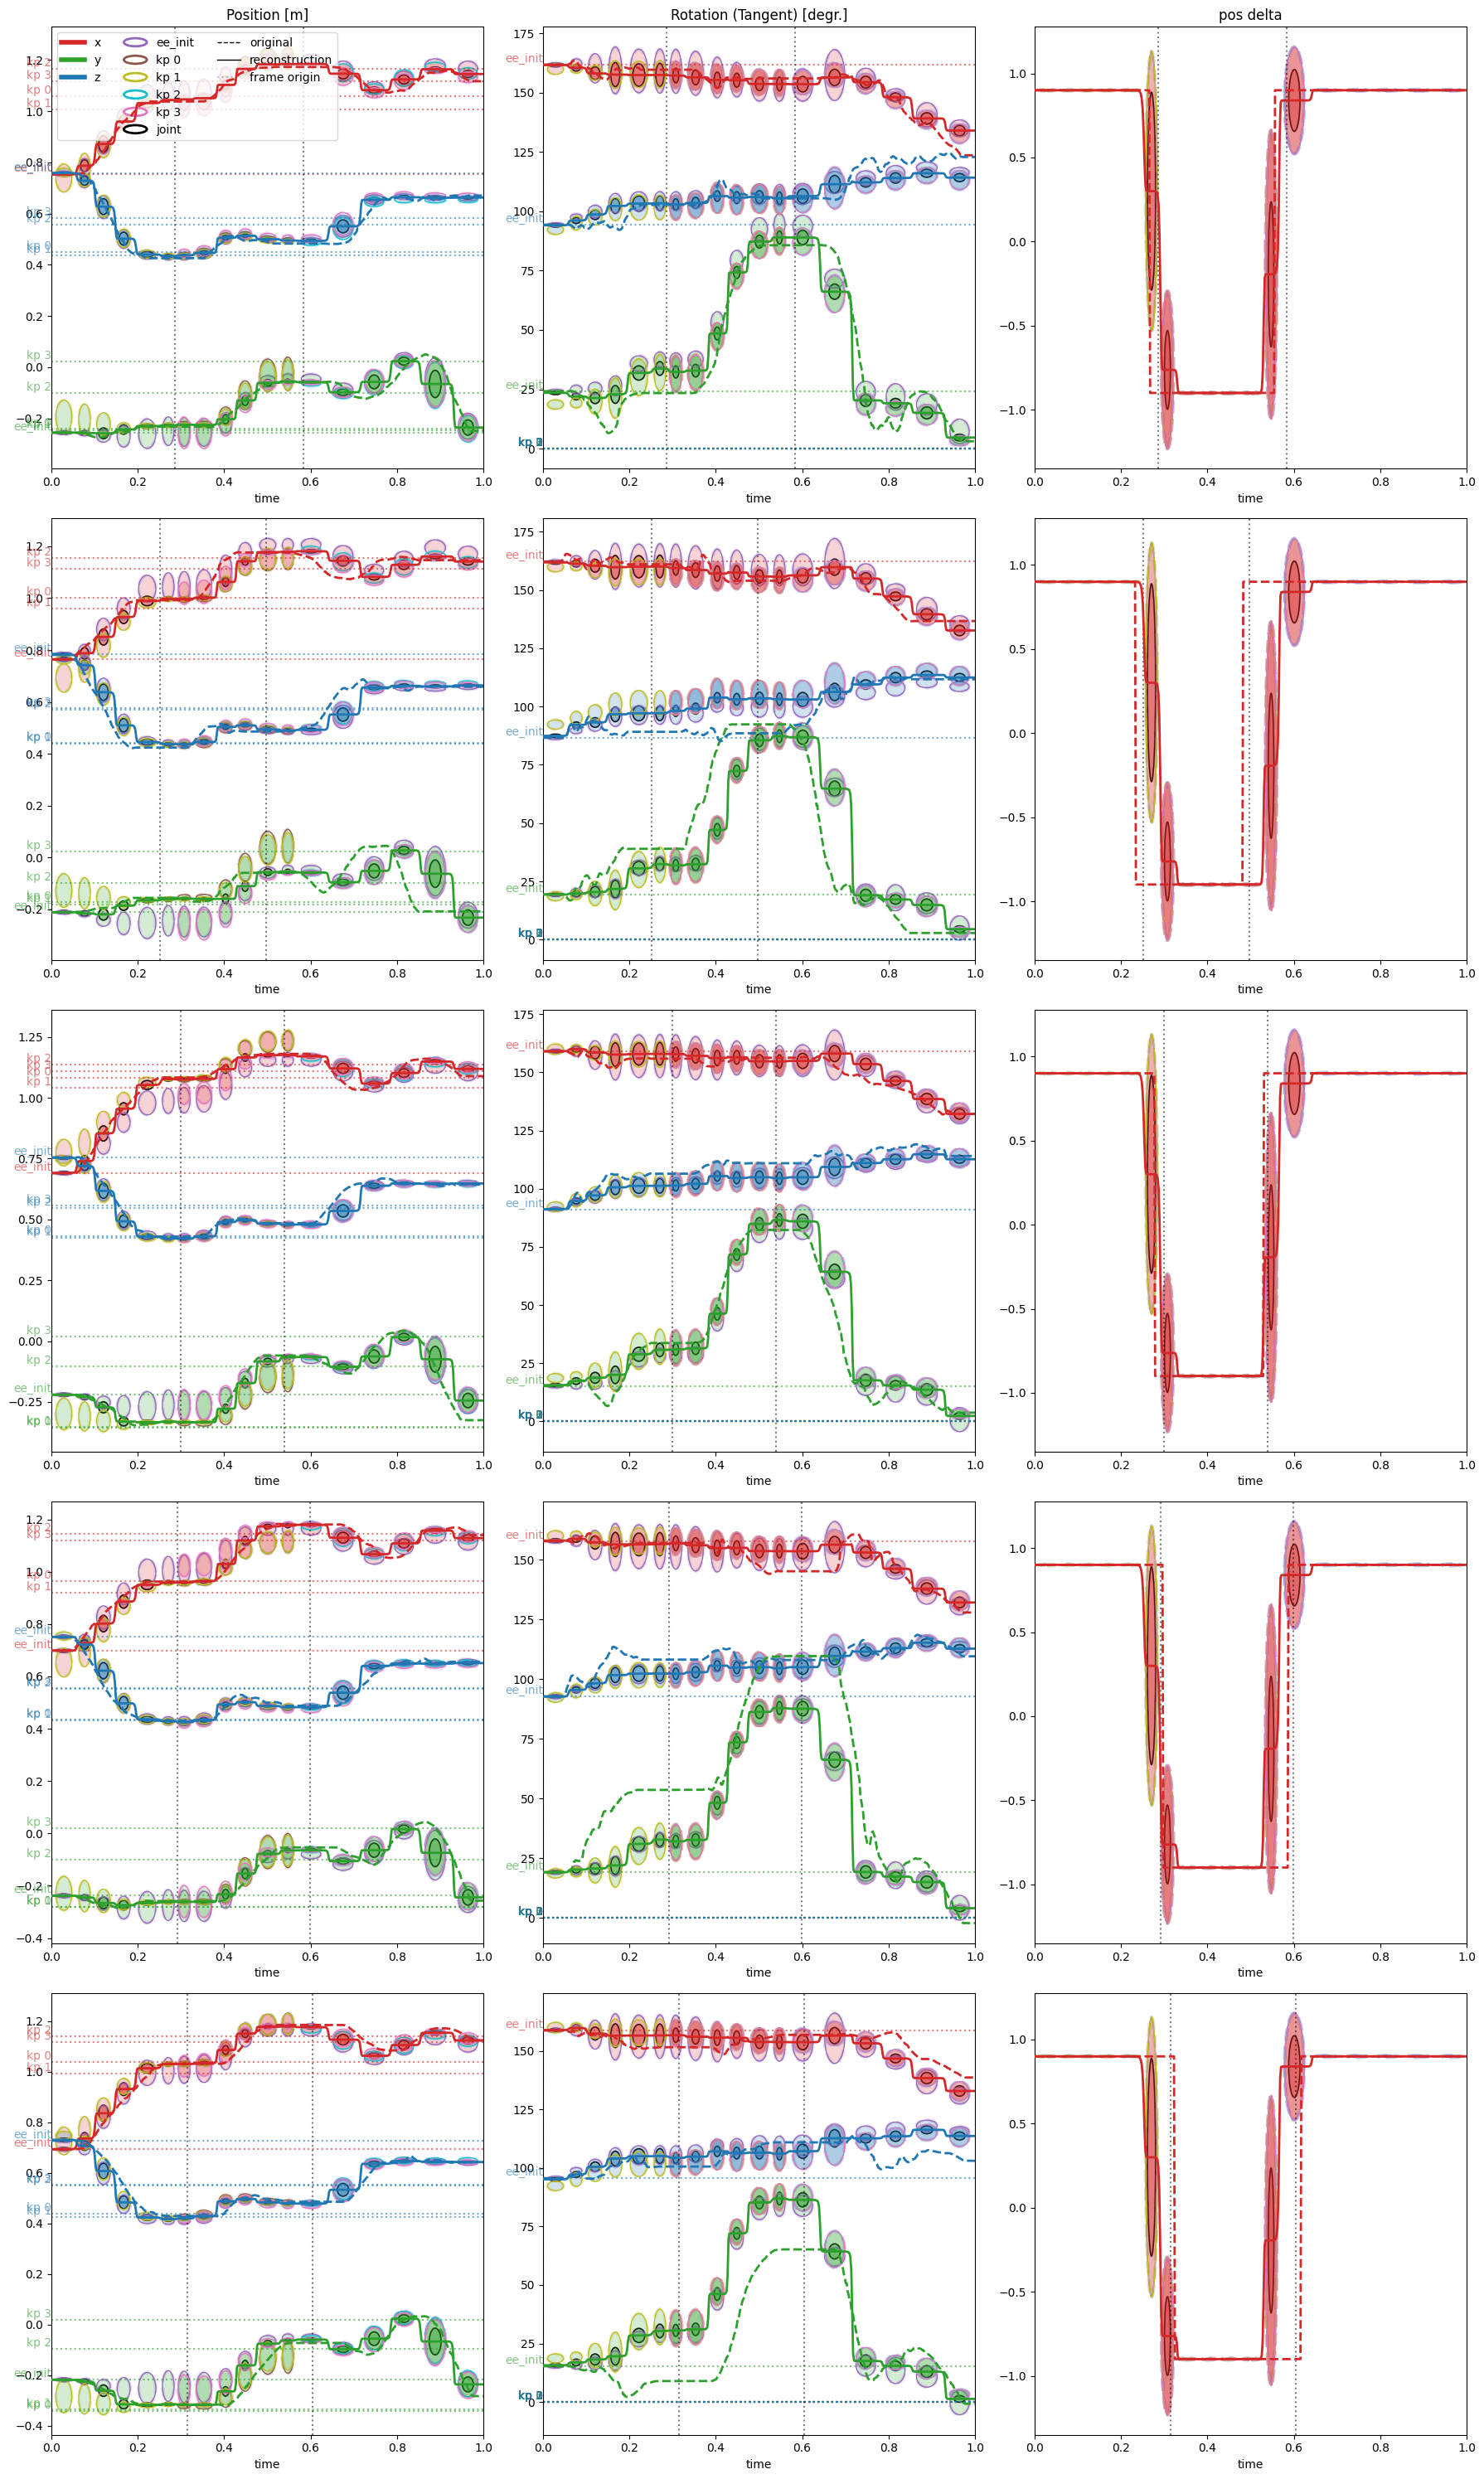

In [20]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


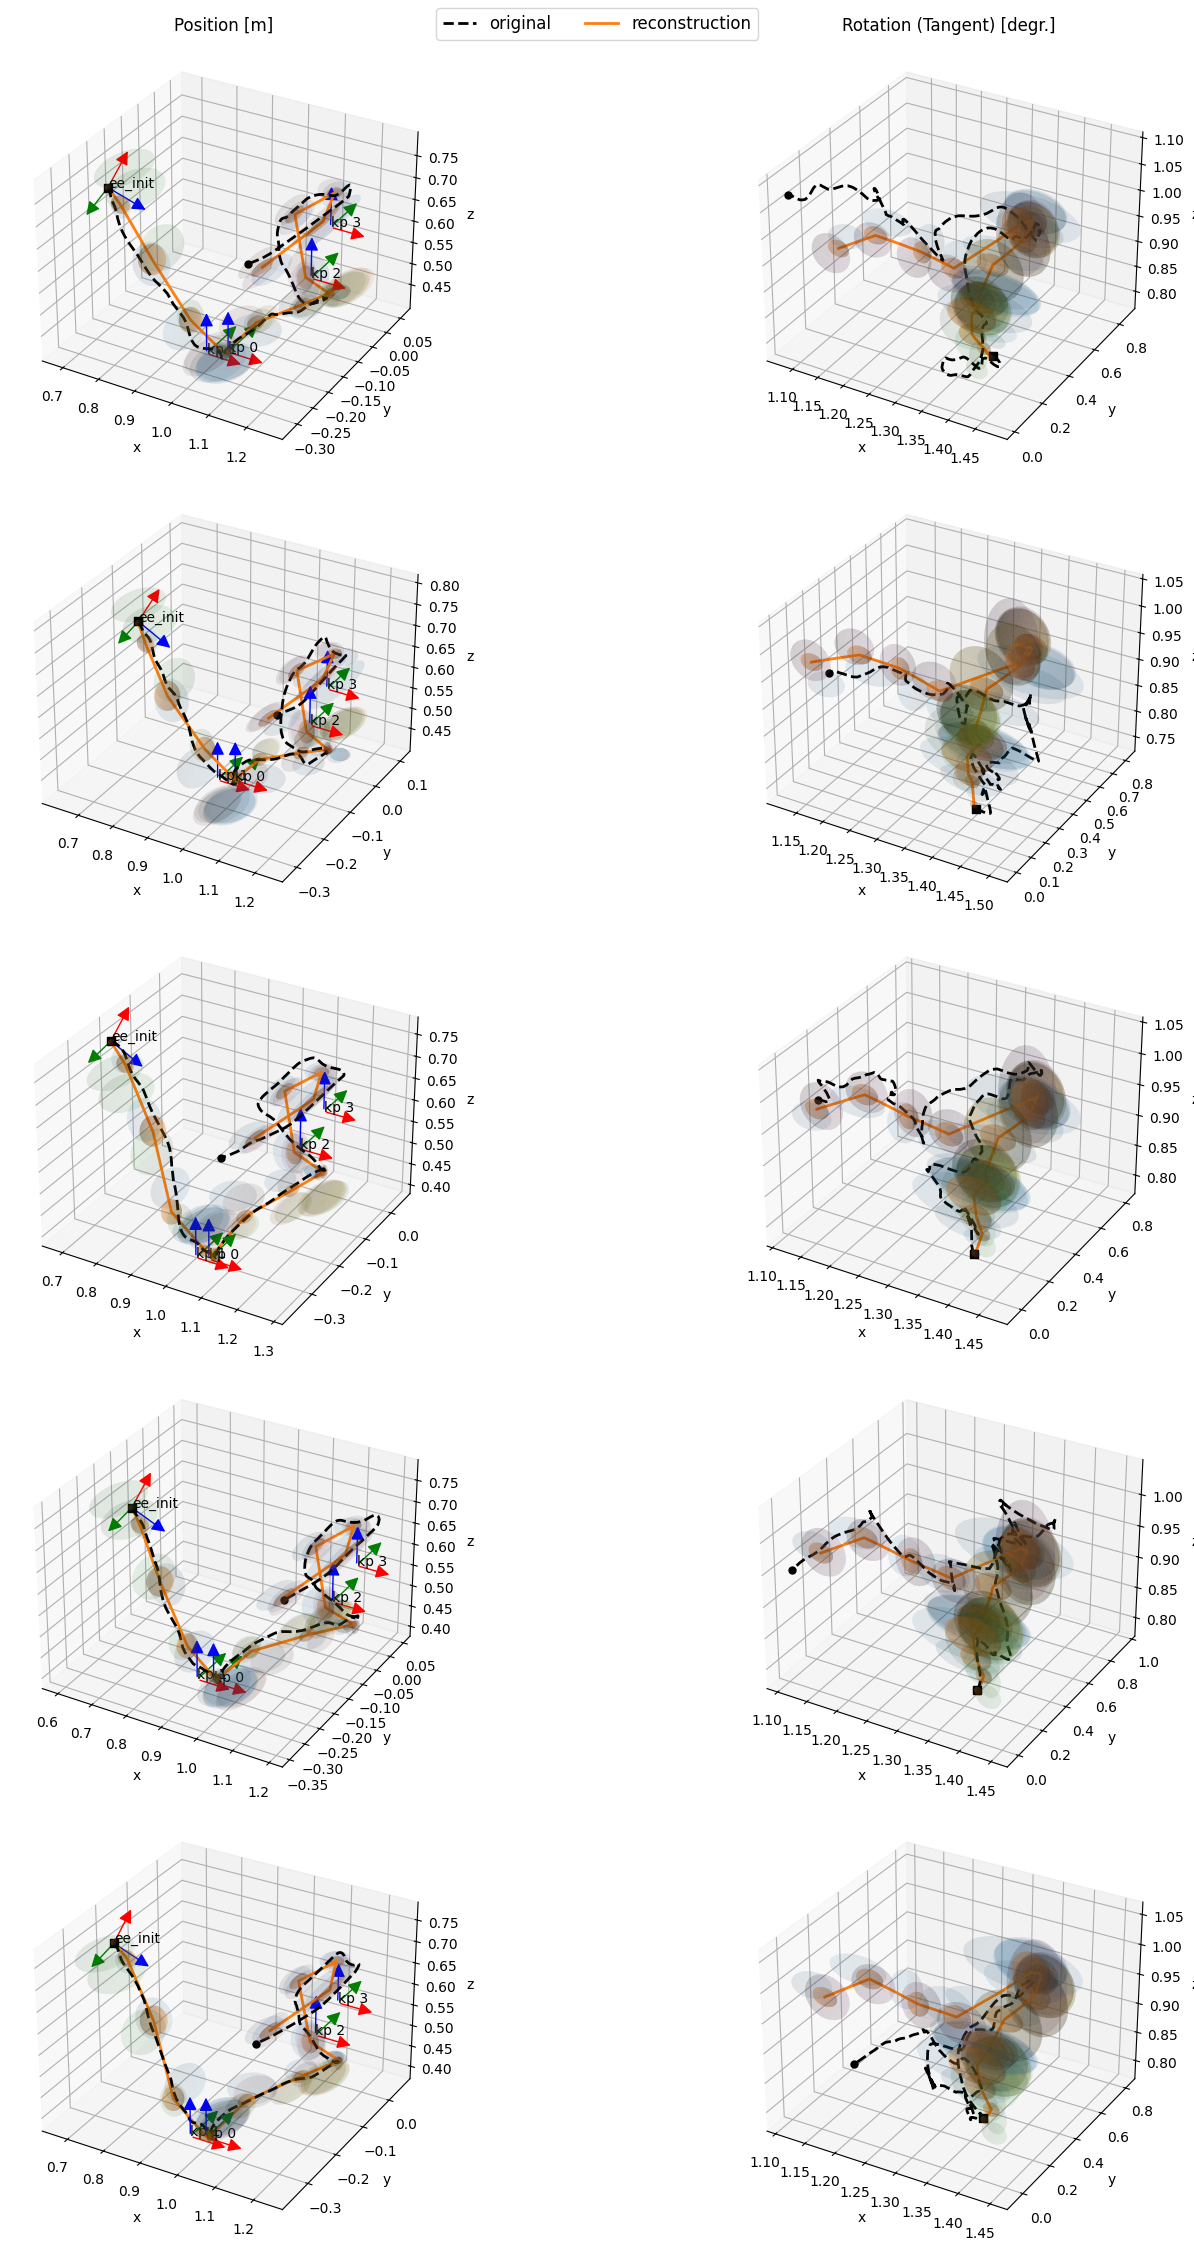

In [21]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=False, per_segment=False)